# Process

* Generate Radiance case files (in HB JSON form) - ./radfiles
* Upload case directory to BLOB
* Spin up pool of nodes to process each individual case
* For each node in the pool, start a docker container capable of running the case


In [71]:
import datetime
import azure.storage.blob as azureblob
import azure.batch.models as batchmodels

# ************************************************** #
# ***   Public methods                           *** #
# ************************************************** #

def create_container(block_blob_client, container_name):
    
    print("Creating container [{0:}]".format(container_name))
    
    return block_blob_client.create_container(container_name, fail_on_exist=False)

def upload_file_to_container(block_blob_client, container_name, file_path):
    """
    Uploads a local file to an Azure Blob storage container.

    :param block_blob_client: A blob service client.
    :type block_blob_client: `azure.storage.blob.BlockBlobService`
    :param str container_name: The name of the Azure Blob storage container.
    :param str file_path: The local path to the file.
    :rtype: `azure.batch.models.ResourceFile`
    :return: A ResourceFile initialized with a SAS URL appropriate for Batch
    tasks.
    """

    blob_name = os.path.basename(file_path)

    print('Uploading file {} to container [{}]'.format(blob_name, container_name))

    block_blob_client.create_blob_from_path(container_name, blob_name, file_path)

    sas_token = block_blob_client.generate_blob_shared_access_signature(container_name, blob_name, permission=azureblob.BlobPermissions.READ, expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=24))

    sas_url = block_blob_client.make_blob_url(container_name, blob_name, sas_token=sas_token)

    return batchmodels.ResourceFile(file_path=blob_name, blob_source=sas_url)

def get_container_sas_token(block_blob_client, container_name, blob_permissions):
    """
    Obtains a shared access signature granting the specified permissions to the container.

    :param block_blob_client: A blob service client.
    :type block_blob_client: `azure.storage.blob.BlockBlobService`
    :param str container_name: The name of the Azure Blob storage container.
    :param BlobPermissions blob_permissions:
    :rtype: str
    :return: A SAS token granting the specified permissions to the container.
    """
    # Obtain the SAS token for the container, setting the expiry time and permissions. In this case, no start time is specified, so the shared access signature becomes valid immediately.
    container_sas_token = \
        block_blob_client.generate_container_shared_access_signature(
            container_name,
            permission=blob_permissions,
            expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=24))

    return container_sas_token

# ************************************************** #
# ***   Main execution                           *** #
# ************************************************** #
if __name__ == "__main__":
    _BATCH_ACCOUNT_NAME = "climatebasedbatch"
    _BATCH_ACCOUNT_KEY = "W94ukoxG2neFkk6teOVZ3IQ8IQjmPJqPcFq48I9lLzCrPEQSRFS/+euaUEkkSyPoulUgnx5IEZxztA9574Hluw=="
    _BATCH_ACCOUNT_URL = "https://climatebasedbatch.westeurope.batch.azure.com"

    _STORAGE_ACCOUNT_NAME = "radfiles"
    _STORAGE_ACCOUNT_KEY = "aRRVzOkO/kwS35CIwNVIa18aGoMfZD5D3yAy3GlorkkU2G+9q5rAscXoC21IIylJZerBefwMgxYYF3qzquALrw=="

    _POOL_ID = "1st_deployment"
    _MIN_POOL_NODE = 1
    _MAX_POOL_NODE = 100

    _POOL_VM_SIZE = "BASIC_A1"
    _NODE_OS_PUBLISHER = "Canonical"
    _NODE_OS_OFFER = "UbuntuServer"
    _NODE_OS_SKU = "16"

    _CONTAINER = "0000000-jobs-3513"

    # ************************************************* #

    # Create the Blob client
    blob_client = azureblob.BlockBlobService(account_name=_STORAGE_ACCOUNT_NAME, account_key=_STORAGE_ACCOUNT_KEY)

    # Create container to hold files
    create_container(blob_client, _CONTAINER)

    # Upload file/s to blob
    file_s = r"C:\Users\tgerrish\Documents\GitHub\BHoM\.gitignore"
    upload_file_to_container(blob_client, _CONTAINER, file_s)
    
    # Get sas token
    sas_token = get_container_sas_token(blob_client, _CONTAINER, azureblob.BlobPermissions.WRITE)
    
    # Create the Batch client
    credentials = batchauth.SharedKeyCredentials(_BATCH_ACCOUNT_NAME, _BATCH_ACCOUNT_KEY)
    batch_client = batch.BatchServiceClient(credentials, base_url=_BATCH_ACCOUNT_URL)
    
    

Creating container [0000000-jobs-3513]
Uploading file .gitignore to container [0000000-jobs-3513]


In [73]:
batch_client

In [70]:
get_container_sas_token(blob_client, _CONTAINER, azureblob.BlobPermissions.WRITE)

'se=2018-08-16T09%3A05%3A49Z&sp=w&sv=2017-04-17&sr=c&sig=lQZepqZTx1yP67EGW2yorXrhPq2quVx8Gxn7I2zrOSc%3D'

In [11]:
# Upload to Blob
# TODO - Convert to argparse-able format!

import azure.storage.blob as azureblob
import time
import os

_UPLOAD = r"C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles"
# _UPLOAD = r"C:\Users\tgerrish\Documents\GitHub\BHoM\.gitignore"
patience = 5

blob_client = azureblob.BlockBlobService(account_name=_STORAGE_ACCOUNT_NAME, account_key=_STORAGE_ACCOUNT_KEY)

blob_client.create_container(_CONTAINER, fail_on_exist=False)
print("\nWaiting for {0:} seconds - letting Azure create the container before uploading files".format(patience))
for t in reversed(range(patience)):
    print("{0:}".format(t+1))
    time.sleep(1)

application_files = []
    
print("\nUploading ...\n")
if os.path.isfile(_UPLOAD):
    application_files.append(blob_client.create_blob_from_path(_CONTAINER, os.path.basename(_UPLOAD), _UPLOAD, timeout=5, max_connections=4))
    print("Container [{1:}/{0:}] created from {2:}".format(os.path.basename(_UPLOAD), _CONTAINER, _UPLOAD))
elif os.path.isdir(_UPLOAD):
    paths = []
    for root, dirs, files in os.walk(os.path.abspath(_UPLOAD)):
        for file in files:
            paths.append(os.path.join(root, file))
    nm = _UPLOAD.split("\\")[-1]
    for file in paths:
        print("Container [{2:}\\{1:}] created from {0:}".format(file, os.path.normpath("{0:}\\{1:}".format(nm, file.replace(_UPLOAD, ""))), _CONTAINER))
        application_files.append(blob_client.create_blob_from_path(_CONTAINER, os.path.normpath("{0:}\\{1:}".format(nm, file.replace(_UPLOAD, ""))), file, timeout=5, max_connections=4))
print("\nUpload succesful!\n")

application_files


Waiting for 5 seconds - letting Azure create the container before uploading files
5
4
3
2
1
Uploading ...
Container [0000000-jobs-3513\radfiles\sky_mtx.json] created from C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles\sky_mtx.json
Container [0000000-jobs-3513\radfiles\surfaces.json] created from C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles\surfaces.json
Container [0000000-jobs-3513\radfiles\AnalysisGrids\zone1.json] created from C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles\AnalysisGrids\zone1.json
Container [0000000-jobs-3513\radfiles\AnalysisGrids\zone2.json] created from C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles\AnalysisGrids\zone2.json
Container [0000000-jobs-3513\radfiles\AnalysisGrids\zone3.json] created from C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\Azure\radfiles\AnalysisGrids\zone3.json
Container [0000000-jobs-3513\radfiles\AnalysisGrids\zone4.json] created from C:\User

In [46]:
# Create pool

import azure.batch.batch_service_client as batch
import azure.batch.batch_auth as batchauth
import azure.batch.models as batchmodels

_POOL_NODE_COUNT = 2

def select_latest_verified_vm_image_with_node_agent_sku(batch_client, publisher, offer, sku_starts_with):
    """Select the latest verified image that Azure Batch supports given a publisher, offer and sku (starts with filter).
    :param batch_client: The batch client to use.
    :type batch_client: `batchserviceclient.BatchServiceClient`
    :param str publisher: vm image publisher
    :param str offer: vm image offer
    :param str sku_starts_with: vm sku starts with filter
    :rtype: tuple
    :return: (node agent sku id to use, vm image ref to use)
    """
    # get verified vm image list and node agent sku ids from service
    node_agent_skus = batch_client.account.list_node_agent_skus()
    # pick the latest supported sku
    skus_to_use = [
        (sku, image_ref) for sku in node_agent_skus for image_ref in sorted(
            sku.verified_image_references, key=lambda item: item.sku)
        if image_ref.publisher.lower() == publisher.lower() and
        image_ref.offer.lower() == offer.lower() and
        image_ref.sku.startswith(sku_starts_with)
    ]
    # skus are listed in reverse order, pick first for latest
    sku_to_use, image_ref_to_use = skus_to_use[0]
    return (sku_to_use.id, image_ref_to_use)

def wrap_commands_in_shell(ostype, commands):
    """Wrap commands in a shell
    :param list commands: list of commands to wrap
    :param str ostype: OS type, linux or windows
    :rtype: str
    :return: a shell wrapping commands
    """
    if ostype.lower() == "linux":
        return "/bin/bash -c \"set -e; set -o pipefail; {}; wait\"".format(";".join(commands))
    elif ostype.lower() == "windows":
        return "cmd.exe /c "{}"".format("&".join(commands))
    else:
        raise ValueError("unknown ostype: {}".format(ostype))

credentials = batchauth.SharedKeyCredentials(_BATCH_ACCOUNT_NAME, _BATCH_ACCOUNT_KEY)
batch_client = batch.BatchServiceClient(credentials, base_url=_BATCH_ACCOUNT_URL)

batch_service_client = batch_client ##################
pool_id = _POOL_ID
resource_files = application_files ###############
publisher = _NODE_OS_PUBLISHER
offer = _NODE_OS_OFFER
sku = _NODE_OS_SKU

task_commands = ["sudo apt-get install docker -y && sudo apt-get install docker.io -y"]

sku_to_use, image_ref_to_use = select_latest_verified_vm_image_with_node_agent_sku(batch_client, publisher, offer, sku)
user = batchmodels.AutoUserSpecification(scope=batchmodels.AutoUserScope.pool, elevation_level=batchmodels.ElevationLevel.admin)
new_pool = batch.models.PoolAddParameter(
    id=pool_id, 
    virtual_machine_configuration=batchmodels.VirtualMachineConfiguration(
        image_reference=image_ref_to_use,
        node_agent_sku_id=sku),
    vm_size=_POOL_VM_SIZE,
    resize_timeout=datetime.timedelta(minutes=15),
    target_dedicated_nodes=_POOL_NODE_COUNT,
    start_task=batch.models.StartTask(
        command_line=wrap_commands_in_shell("linux", task_commands), 
        user_identity=batchmodels.UserIdentity(
            auto_user=user
        ), 
        wait_for_success=True,
        resource_files=resource_files
    ),
)

new_pool

'1st_deployment'

In [50]:
# Create job

def create_job(batch_service_client, job_id, pool_id):
    """
    Creates a job with the specified ID, associated with the specified pool.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str job_id: The ID for the job.
    :param str pool_id: The ID for the pool.
    """
    print('Creating job [{}]...'.format(job_id))

    job = batch.models.JobAddParameter(
        job_id,
        batch.models.PoolInformation(pool_id=pool_id))

    try:
        batch_service_client.job.add(job)
    except batchmodels.batch_error.BatchErrorException as err:
        print_batch_exception(err)
        raise

create_job(batch_client, "jobtest", new_pool.id)

Creating job [jobtest]...


In [ ]:
# Create task

In [ ]:
# Run commands from task on node. For example, bash > pull files > docker run, mapped to file directory

In [ ]:
# Extract results to Blob

In [ ]:
      command = [ 'sudo bash',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job:z antoinedao/radhoneywhale unzip /usr/job/{} -d /usr/job/'.format(input_file_names[idx]),
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale python3 /usr/convertToBash.py '
                    '--filepath /usr/job',
                    'sudo chmod +x $AZ_BATCH_TASK_WORKING_DIR/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale /usr/job/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale zip -r /usr/job/out_{} /usr/job/'.format(filename + ".zip"),
                    'python $AZ_BATCH_NODE_SHARED_DIR/copyToBlob.py '
                    '--filepath $AZ_BATCH_TASK_WORKING_DIR/{} --filename {} --storageaccount {} '
                    '--storagecontainer {} --sastoken "{}"'.format(
                     'out_'+filename + ".zip",
                     'out_'+filename + ".zip",
                     _STORAGE_ACCOUNT_NAME,
                     output_container_name,
                     output_container_sas_token)]

In [ ]:
def add_tasks(batch_service_client, job_id, input_files,
              input_file_names, output_container_name, output_container_sas_token):
    """
    Adds a task for each input file in the collection to the specified job.
    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str job_id: The ID of the job to which to add the tasks.
    :param list input_files: A collection of input files. One task will be created for each input file.
    :param output_container_name: The ID of an Azure Blob storage container to which the tasks will upload their results.
    :param output_container_sas_token: A SAS token granting write access to the specified Azure Blob storage container.
    """

    print('Adding {} tasks to job [{}]...'.format(len(input_files), job_id))

    user = batchmodels.UserIdentity(
    auto_user=batchmodels.AutoUserSpecification(
        elevation_level=batchmodels.ElevationLevel.admin,
        scope=batchmodels.AutoUserScope.task))

    tasks = list()

    for idx, input_file in enumerate(input_files):
        filename = input_file_names[idx].split(".")[0]

        command = [ 'sudo bash',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job:z antoinedao/radhoneywhale unzip /usr/job/{} -d /usr/job/'.format(input_file_names[idx]),
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale python3 /usr/convertToBash.py '
                    '--filepath /usr/job',
                    'sudo chmod +x $AZ_BATCH_TASK_WORKING_DIR/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale /usr/job/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale zip -r /usr/job/out_{} /usr/job/'.format(filename + ".zip"),
                    'python $AZ_BATCH_NODE_SHARED_DIR/copyToBlob.py '
                    '--filepath $AZ_BATCH_TASK_WORKING_DIR/{} --filename {} --storageaccount {} '
                    '--storagecontainer {} --sastoken "{}"'.format(
                     'out_'+filename + ".zip",
                     'out_'+filename + ".zip",
                     _STORAGE_ACCOUNT_NAME,
                     output_container_name,
                     output_container_sas_token)]

        tasks.append(batch.models.TaskAddParameter(
                'Task_{}'.format(idx,filename),
                common.helpers.wrap_commands_in_shell('linux', command),
                resource_files=[input_file],
                user_identity=user
                )
        )

    batch_service_client.task.add_collection(job_id, tasks)

(0, 1)

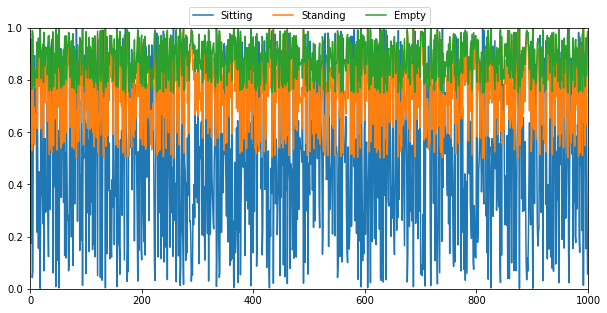

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

vals = 1000
total = 100
sitting = np.random.rand(vals)
standing = 1 - (sitting / 2)
empty = 1 - (sitting / 4)

fig, ax = plt.subplots(1, 1, figsize=(10, 4.8))
ax.plot(np.arange(0, vals, 1), sitting, label="Sitting")
ax.plot(np.arange(0, vals, 1), standing, label="Standing")
ax.plot(np.arange(0, vals, 1), empty, label="Empty")

lgd = ax.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.1))

ax.set_xlim([0, vals])
ax.set_ylim([0, 1])

In [ ]:
# TODO -  Add a check to see if the container exists before uploading files

In [1]:
from __future__ import print_function
import datetime
import os
import sys
import time

try:
    input = raw_input
except NameError:
    pass

import azure.storage.blob as azureblob
import azure.batch.batch_service_client as batch
import azure.batch.batch_auth as batchauth
import azure.batch.models as batchmodels

sys.path.append('.')
sys.path.append('..')
# import common.helpers  # noqa

import shutil

# Setup and credentials

In [2]:
# Update the Batch and Storage account credential strings below with the values
# unique to your accounts. These are used when constructing connection strings
# for the Batch and Storage client objects.
_BATCH_ACCOUNT_NAME = "climatebasedbatch"
_BATCH_ACCOUNT_KEY = "W94ukoxG2neFkk6teOVZ3IQ8IQjmPJqPcFq48I9lLzCrPEQSRFS/+euaUEkkSyPoulUgnx5IEZxztA9574Hluw=="
_BATCH_ACCOUNT_URL = "https://climatebasedbatch.westeurope.batch.azure.com"

_STORAGE_ACCOUNT_NAME = "radfiles"
_STORAGE_ACCOUNT_KEY = "aRRVzOkO/kwS35CIwNVIa18aGoMfZD5D3yAy3GlorkkU2G+9q5rAscXoC21IIylJZerBefwMgxYYF3qzquALrw=="

# Input the name for your job as well as the name of the pool you want to create.
# Remember that for now it seems impossible to send more than 100 tasks per job
# so I have set up some autoscaling capability lower down in the script. If you
# more than 100 sims to run, the script will just create a new job with the same
# name + i.
# _JOB_ID =

_POOL_ID = "1st_deployment"
_MIN_POOL_NODE = 1
_MAX_POOL_NODE = 100

# Don't touch this stuff unless you know what you're doing! The startup commands
# and task commands are written for bash in linux. You can maybe change the vm_size
# but to be honest I find a normal room runs fine on the Basic A1 sized VM and it
# costs £0.014/hour.
_POOL_VM_SIZE = 'BASIC_A1'
_NODE_OS_PUBLISHER = 'Canonical'
_NODE_OS_OFFER = 'UbuntuServer'
_NODE_OS_SKU = '16'

# Scripts to be run to run different recipe types
_RADIATION = "honeybee_scripts/run_radiation.py"
_DAYLIGHT_FACTOR = "honeybee_scripts/run_daylight_factor.py"
_ANNUAL = "honeybee_scripts/run_annual.py"
_DAYLIGHT_COEFF = "honeybee_scripts/run_daylight_coeff.py"

# Script to send outputs back to blob storage
_COPY_TO_OUTPUT = 'copyToBlob.py'

## Create the blob client
For use in obtaining references to blob storage containers and uploading files to containers.

In [3]:
blob_client = azureblob.BlockBlobService(
    account_name=_STORAGE_ACCOUNT_NAME,
    account_key=_STORAGE_ACCOUNT_KEY
)

## Upload resource files into the blob
<font size="5" style="color:red">This only really needs to be run each time the resource files change.</font>

In [5]:
# Copy the file back to the blob
import azure.storage.blob as azureblob
import os
import argparse

# Write a file containing something awesome!
with open("test_output.txt", "w") as f:
    f.write("If you're reading this ... it worked!!! Also, Hello World!")

parser = argparse.ArgumentParser()
parser.add_argument(
    '--filepath',
    required=True,
    help='The path to the text file to process. The path may include a compute node\'s environment variables, such as $AZ_BATCH_NODE_SHARED_DIR/filename.txt'
)

parser.add_argument(
    '--blobname',
    required=True,
    help='The full path the file should be saved to on theblob storage'
)

parser.add_argument(
    '--storageaccount',
    required=True,
    help='The name the Azure Storage account that owns the blob storage container to which to upload results.'
)

parser.add_argument(
    '--storagecontainer',
    required=True,
    help='The Azure Blob storage container to which to upload results.'
)

parser.add_argument(
    '--sastoken',
    required=True,
    help='The SAS token providing write access to the Storage container.'
)

args = parser.parse_args()

# Create the blob client using the container's SAS token. This allows us to create a client that provides write access only to the container.
blob_client = azureblob.BlockBlobService(
    account_name=args.storageaccount,
    sas_token=args.sastoken
)

print(
    'Uploading file {} to container [{}]...'.format(
        args.blobname.rsplit("/", 1)[1],
        args.storagecontainer
    )
)

blob_client.create_blob_from_path(
    args.storagecontainer,
    args.blobname,
    args.filepath
)

In [67]:
import os

objects = r"C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee"

# Get the paths to all files in the selected directory
paths = []
for root, dirs, files in os.walk(os.path.abspath(objects)):
    for file in files:
        paths.append(os.path.os.path.join(root, file))
# Obtain the common prefix to each file
common_prefix = os.path.commonprefix(paths)

# Get name of directory being sent
nm = objects.split("\\")[-1]

for file in paths:
    print("File to upload: {0:}".format(file))
    print(os.path.normpath("{0:}\\{1:}".format(nm, file.replace(objects, ""))))
    print(nm)
paths[0].replace(objects, "")

#paths[0]#.replace(common_prefix, "")

File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\config.json
honeybee\honeybee\config.json
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\config.py
honeybee\honeybee\config.py
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\config.pyc
honeybee\honeybee\config.pyc
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\dataoperation.py
honeybee\honeybee\dataoperation.py
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\dataoperation.pyc
honeybee\honeybee\dataoperation.pyc
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\futil.py
honeybee\honeybee\futil.py
honeybee
File to upload: C:\Users\tgerrish\Documents\GitHub\SAMAzure\TestFiles\honeybee\honeybee\futil.pyc
honeybee\honeybee\futil.pyc
honeybee
File to upload: C:\Us

'\\honeybee\\config.json'

In [ ]:
_BLOB_RESOURCE_CONTAINER = "0000000-resources"

_RESOURCES = [
    r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\FilePreparation\honeybee",
    r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\FilePreparation\ladybug",
    r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\FilePreparation\02_run_radiance_case.py",
    r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\FilePreparation\radiance-5.1.0-Linux.tar.gz"
]

# Create resources blob location
blob_client.create_container(_BLOB_RESOURCE_CONTAINER, fail_on_exist=False)

time.sleep(10)  # Sleep for a bit to wait for Azure to create the container

for obj in _RESOURCES:
    # If the resource is a directory, zip and upload the zipped archive
    if os.path.isdir(obj):
        shutil.make_archive("{0:}".format(obj), 'gztar', obj)
        print("Uploading ../{0:}.tar.gz to container [{2:}/{1:}]".format(os.path.basename(obj), os.path.basename("{0:}.tar.gz".format(obj)), _BLOB_RESOURCE_CONTAINER))
        blob_client.create_blob_from_path(_BLOB_RESOURCE_CONTAINER, os.path.basename("{0:}.tar.gz".format(obj)), "{0:}.tar.gz".format(obj), timeout=5, max_connections=4)
        os.remove("{0:}.tar.gz".format(obj))
    if os.path.isfile(obj):
        print("Uploading ../{0:} to container [{1:}/{0:}]".format(os.path.basename(obj), _BLOB_RESOURCE_CONTAINER))
        blob_client.create_blob_from_path(_BLOB_RESOURCE_CONTAINER, os.path.basename(obj), obj, timeout=5, max_connections=4)

print("\nResource files uploaded")

## Upload the data files
This creates a container in blob storage in which the files to be processed by each of the tasks executed on the compute nodes in the pool.

https://docs.microsoft.com/en-us/python/api/azure-storage-blob/azure.storage.blob.blockblobservice.blockblobservice?view=azure-python

In [ ]:
_SOURCE_DIRECTORY = r"C:\Users\tgerrish\Desktop\SAMAzure\TestFiles\FilePreparation\0000000"
_BLOB_TARGET_CONTAINER = "0000000-testproject-3513"
wait_time = 10

# Create the top level container with the same name as the project
blob_client.create_container(_BLOB_TARGET_CONTAINER, fail_on_exist=False)

# Get the list of files within the source directory to upload
source_paths = [item for sublist in [[os.path.join(path, name) for name in files] for path, subdirs, files in os.walk(_SOURCE_DIRECTORY)] for item in sublist]

try:
    # Upload the files
    file_dict = {}
    grid_dict = {}
    for obj in source_paths:
        if "sky_mtx.json" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            file_dict["sky_matrix"] = a
        if "surfaces.json" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            file_dict["surfaces"] = a
        if "AnalysisGrid" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            grid_dict[os.path.basename(obj).replace(".json", "")] = a
        print("Uploading ../{0:} to container [{1:}/{0:}]".format(obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), _BLOB_TARGET_CONTAINER))
except:
    print("Looks like the container hasn't been created just yet ... I'll wait for {0:} seconds ...".format(wait_time))
    
    # Sleep for a bit to wait for Azure to create the container - If you get the error "AzureMissingResourceHttpError: The specified container does not exist.", try increasing this value
    time.sleep(wait_time)
    
    # Upload the files
    file_dict = {}
    grid_dict = {}
    for obj in source_paths:
        if "sky_mtx.json" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            file_dict["sky_matrix"] = a
        if "surfaces.json" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            file_dict["surfaces"] = a
        if "AnalysisGrid" in obj:
            a = blob_client.create_blob_from_path(_BLOB_TARGET_CONTAINER, obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), obj, timeout=5)
            grid_dict[os.path.basename(obj).replace(".json", "")] = a
        print("Uploading ../{0:} to container [{1:}/{0:}]".format(obj.replace("{0:}\\".format(_SOURCE_DIRECTORY), "").replace("\\", "/"), _BLOB_TARGET_CONTAINER))

print("\nResource files uploaded")

## Get credentials for writing data to the project blob container
Obtains a shared access signature that provides write access to the output container to which the tasks will upload their output.

In [9]:
output_container_sas_token = blob_client.generate_container_shared_access_signature(
            _BLOB_TARGET_CONTAINER,
            permission=azureblob.BlobPermissions.WRITE,
            expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=24)
)

output_container_sas_token

'se=2018-08-07T07%3A36%3A12Z&sp=w&sv=2017-04-17&sr=c&sig=eaaX/v3HGfnmS2SQQH7OjqQCF1b5w0ZY12DhxD%2BzBe8%3D'

## Create a Batch service client
We'll now be interacting with the Batch service in addition to Storage.

In [10]:
credentials = batchauth.SharedKeyCredentials(_BATCH_ACCOUNT_NAME, _BATCH_ACCOUNT_KEY)
                                             
batch_client = batch.BatchServiceClient(credentials, base_url=_BATCH_ACCOUNT_URL)

## Create pool!

In [14]:
def create_pool(batch_service_client, pool_id,
                resource_files, publisher, offer, sku):
    """
    Creates a pool of compute nodes with the specified OS settings.
    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str pool_id: An ID for the new pool.
    :param list resource_files: A collection of resource files for the pool's
    start task.
    :param str publisher: Marketplace image publisher
    :param str offer: Marketplace image offer
    :param str sku: Marketplace image sku
    """
    print('Creating pool [{}]...'.format(pool_id))

    # Create a new pool of Linux compute nodes using an Azure Virtual Machines
    # Marketplace image. For more information about creating pools of Linux
    # nodes, see:
    # https://azure.microsoft.com/documentation/articles/batch-linux-nodes/

    # Specify the commands for the pool's start task. The start task is run
    # on each node as it joins the pool, and when it's rebooted or re-imaged.
    # We use the start task to prep the node for running our task script.
    task_commands = [
        # Copy the python_tutorial_task.py script to the "shared" directory
        # that all tasks that run on the node have access to. Note that
        # we are using the -p flag with cp to preserve the file uid/gid,
        # otherwise since this start task is run as an admin, it would not
        # be accessible by tasks run as a non-admin user.
        # 'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_BAT_TO_BASH),
        'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_COPY_TO_OUTPUT),
        ############################
        # Install the relevant files
        ############################
        # Update Ubuntu
        #"apt-get update",
        # Install git
        #"apt-get install git-core -y",
        # Install rsync
        #"apt-get install rsync -y"
        # Install pip
        "apt-get install python-pip -y"
        # Install the azure-storage module so that the task script can access Azure Blob storage, pre-cryptography version
        'pip install azure-storage==0.32.0',
        # Install Radiance
        #"curl -fsSL https://github.com/NREL/Radiance/releases/download/5.1.0/radiance-5.1.0-Linux.tar.gz -o radiance-5.1.0-Linux.tar.gz",
        #"tar xzf radiance-5.1.0-Linux.tar.gz",
        #"rsync -av /radiance-5.1.0-Linux/usr/local/radiance/bin/ /usr/local/bin/",
        #"rsync -av /radiance-5.1.0-Linux/usr/local/radiance/lib/ /usr/local/lib/ray/ --remove-source-files"
        # Copy honeybee ladybug zip from github
        
        # Install docker
#         'sudo apt-get install docker -y && sudo apt-get install docker.io -y',
        # Pull RadHoneyWhale from docker hub
#         'sudo docker pull antoinedao/radhoneywhale',
        # Install git
        #"sudo apt-get install git"
    ]


    # Get the node agent SKU and image reference for the virtual machine
    # configuration.
    # For more information about the virtual machine configuration, see:
    # https://azure.microsoft.com/documentation/articles/batch-linux-nodes/
    sku_to_use, image_ref_to_use = \
        common.helpers.select_latest_verified_vm_image_with_node_agent_sku(
            batch_service_client, publisher, offer, sku)
    user = batchmodels.AutoUserSpecification(
        scope=batchmodels.AutoUserScope.pool,
        elevation_level=batchmodels.ElevationLevel.admin)
    new_pool = batch.models.PoolAddParameter(
        id=pool_id,
        virtual_machine_configuration=batchmodels.VirtualMachineConfiguration(
            image_reference=image_ref_to_use,
            node_agent_sku_id=sku_to_use),
        vm_size=_POOL_VM_SIZE,
        resize_timeout=datetime.timedelta(minutes=15),
        target_dedicated_nodes=_POOL_NODE_COUNT,
        start_task=batch.models.StartTask(
            command_line=common.helpers.wrap_commands_in_shell('linux',
                                                               task_commands),
            user_identity=batchmodels.UserIdentity(auto_user=user),
            wait_for_success=True,
            resource_files=resource_files),
    )

    try:
        batch_service_client.pool.add(new_pool)
    except batchmodels.batch_error.BatchErrorException as err:
        print_batch_exception(err)
        raise
        
create_pool(batch_client,
                _POOL_ID,
                application_files,
                _NODE_OS_PUBLISHER,
                _NODE_OS_OFFER,
                _NODE_OS_SKU)

NameError: name 'application_files' is not defined

In [18]:
# Copy file from the blob to a host machine

from datetime import datetime, timedelta
from azure.storage.blob import (
    BlockBlobService,
    ContainerPermissions,
)

accountName = "radfiles"
accountKey = "aRRVzOkO/kwS35CIwNVIa18aGoMfZD5D3yAy3GlorkkU2G+9q5rAscXoC21IIylJZerBefwMgxYYF3qzquALrw=="
containerName = "0000000-testproject-3513"

blobService = BlockBlobService(account_name=accountName, account_key=accountKey)
sas_token = blobService.generate_container_shared_access_signature(containerName,ContainerPermissions.READ, datetime.utcnow() + timedelta(hours=1))
print(sas_token)

blobService = BlockBlobService(account_name=accountName, account_key=None, sas_token=sas_token)
blobService.get_blob_to_path(containerName, "test.py", "_00_testING.py")
          
    
# _BATCH_ACCOUNT_NAME = "climatebasedbatch"
# _BATCH_ACCOUNT_KEY = "W94ukoxG2neFkk6teOVZ3IQ8IQjmPJqPcFq48I9lLzCrPEQSRFS/+euaUEkkSyPoulUgnx5IEZxztA9574Hluw=="
# _BATCH_ACCOUNT_URL = "https://climatebasedbatch.westeurope.batch.azure.com"

# _STORAGE_ACCOUNT_NAME = "radfiles"
# _STORAGE_ACCOUNT_KEY = "aRRVzOkO/kwS35CIwNVIa18aGoMfZD5D3yAy3GlorkkU2G+9q5rAscXoC21IIylJZerBefwMgxYYF3qzquALrw=="


se=2018-08-06T09%3A06%3A20Z&sp=r&sv=2017-04-17&sr=c&sig=ASzEKW2e0Jq0PHgpYwhyO8hmRys5PrlfJCA3gXPuiHQ%3D


________________________

In [ ]:
def create_pool(batch_service_client, pool_id, resource_files, publisher, offer, sku):
    """
    Creates a pool of compute nodes with the specified OS settings.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str pool_id: An ID for the new pool.
    :param list resource_files: A collection of resource files for the pool's
    start task.
    :param str publisher: Marketplace image publisher
    :param str offer: Marketplace image offer
    :param str sku: Marketplace image sku
    """
    print('Creating pool [{}]...'.format(pool_id))

    # Specify the commands for the pool's start task. The start task is run
    # on each node as it joins the pool, and when it's rebooted or re-imaged.
    # We use the start task to prep the node for running our task script.
    task_commands = [
        # Copy the python_tutorial_task.py script to the "shared" directory
        # that all tasks that run on the node have access to. Note that
        # we are using the -p flag with cp to preserve the file uid/gid,
        # otherwise since this start task is run as an admin, it would not
        # be accessible by tasks run as a non-admin user.
        # 'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_BAT_TO_BASH),
        'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_COPY_TO_OUTPUT),
        # Install pip
        'curl -fSsL https://bootstrap.pypa.io/get-pip.py | python',
        # Install the azure-storage module so that the task script can access
        # Azure Blob storage, pre-cryptography version
        'pip install azure-storage==0.32.0',
        # Install docker
        'sudo apt-get install docker -y && sudo apt-get install docker.io -y',
        # Pull RadHoneyWhale from docker hub
        'sudo docker pull antoinedao/radhoneywhale']


    # Get the node agent SKU and image reference for the virtual machine
    # configuration.
    # For more information about the virtual machine configuration, see:
    # https://azure.microsoft.com/documentation/articles/batch-linux-nodes/
    sku_to_use, image_ref_to_use = \
        common.helpers.select_latest_verified_vm_image_with_node_agent_sku(
            batch_service_client, publisher, offer, sku)
    user = batchmodels.AutoUserSpecification(
        scope=batchmodels.AutoUserScope.pool,
        elevation_level=batchmodels.ElevationLevel.admin)
    new_pool = batch.models.PoolAddParameter(
        id=pool_id,
        virtual_machine_configuration=batchmodels.VirtualMachineConfiguration(
            image_reference=image_ref_to_use,
            node_agent_sku_id=sku_to_use),
        vm_size=_POOL_VM_SIZE,
        resize_timeout=datetime.timedelta(minutes=15),
        target_dedicated_nodes=_POOL_NODE_COUNT,
        start_task=batch.models.StartTask(
            command_line=common.helpers.wrap_commands_in_shell('linux',
                                                               task_commands),
            user_identity=batchmodels.UserIdentity(auto_user=user),
            wait_for_success=True,
            resource_files=resource_files),
    )

    try:
        batch_service_client.pool.add(new_pool)
    except batchmodels.batch_error.BatchErrorException as err:
        print_batch_exception(err)
        raise


# Create the pool that will contain the compute nodes that will execute the
# tasks. The resource files we pass in are used for configuring the pool's
# start task, which is executed each time a node first joins the pool (or
# # is rebooted or re-imaged).
create_pool(batch_client,
            _POOL_ID,
            application_files,
            _NODE_OS_PUBLISHER,
            _NODE_OS_OFFER,
            _NODE_OS_SKU)


In [ ]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
def upload_file_to_container(block_blob_client, container_name, file_path):
    """
    Uploads a local file to an Azure Blob storage container.

    :param block_blob_client: A blob service client.
    :type block_blob_client: `azure.storage.blob.BlockBlobService`
    :param str container_name: The name of the Azure Blob storage container.
    :param str file_path: The local path to the file.
    :rtype: `azure.batch.models.ResourceFile`
    :return: A ResourceFile initialized with a SAS URL appropriate for Batch
    tasks.
    """

    import datetime
    import azure.storage.blob as azureblob
    import azure.batch.models as batchmodels

    blob_name = os.path.basename(file_path)
    #blob_name = "/".join(os.path.split(file_path))

    print('Uploading file {} to container [{}]...'.format(blob_name,
                                                          container_name))

    block_blob_client.create_blob_from_path(container_name,
                                            blob_name,
                                            file_path)

    sas_token = block_blob_client.generate_blob_shared_access_signature(
        container_name,
        blob_name,
        permission=azureblob.BlobPermissions.READ,
        expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=24))

    sas_url = block_blob_client.make_blob_url(container_name,
                                              blob_name,
                                              sas_token=sas_token)

    return batchmodels.ResourceFile(file_path=blob_name,
                                    blob_source=sas_url)

def get_container_sas_token(block_blob_client,
                            container_name, blob_permissions):
    """
    Obtains a shared access signature granting the specified permissions to the
    container.

    :param block_blob_client: A blob service client.
    :type block_blob_client: `azure.storage.blob.BlockBlobService`
    :param str container_name: The name of the Azure Blob storage container.
    :param BlobPermissions blob_permissions:
    :rtype: str
    :return: A SAS token granting the specified permissions to the container.
    """
    # Obtain the SAS token for the container, setting the expiry time and
    # permissions. In this case, no start time is specified, so the shared
    # access signature becomes valid immediately.
    container_sas_token = \
        block_blob_client.generate_container_shared_access_signature(
            container_name,
            permission=blob_permissions,
            expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=24))

    return container_sas_token

def create_pool(batch_service_client, pool_id, resource_files, publisher, offer, sku):
    """
    Creates a pool of compute nodes with the specified OS settings.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str pool_id: An ID for the new pool.
    :param list resource_files: A collection of resource files for the pool's
    start task.
    :param str publisher: Marketplace image publisher
    :param str offer: Marketplace image offer
    :param str sku: Marketplace image sku
    """
    print('Creating pool [{}]...'.format(pool_id))

    # Specify the commands for the pool's start task. The start task is run
    # on each node as it joins the pool, and when it's rebooted or re-imaged.
    # We use the start task to prep the node for running our task script.
    task_commands = [
        # Copy the python_tutorial_task.py script to the "shared" directory
        # that all tasks that run on the node have access to. Note that
        # we are using the -p flag with cp to preserve the file uid/gid,
        # otherwise since this start task is run as an admin, it would not
        # be accessible by tasks run as a non-admin user.
        # 'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_BAT_TO_BASH),
        'cp -p {} $AZ_BATCH_NODE_SHARED_DIR'.format(_COPY_TO_OUTPUT),
        # Install pip
        'curl -fSsL https://bootstrap.pypa.io/get-pip.py | python',
        # Install the azure-storage module so that the task script can access
        # Azure Blob storage, pre-cryptography version
        'pip install azure-storage==0.32.0',
        # Install docker
        'sudo apt-get install docker -y && sudo apt-get install docker.io -y',
        # Pull RadHoneyWhale from docker hub
        'sudo docker pull antoinedao/radhoneywhale']


    # Get the node agent SKU and image reference for the virtual machine
    # configuration.
    # For more information about the virtual machine configuration, see:
    # https://azure.microsoft.com/documentation/articles/batch-linux-nodes/
    sku_to_use, image_ref_to_use = \
        common.helpers.select_latest_verified_vm_image_with_node_agent_sku(
            batch_service_client, publisher, offer, sku)
    user = batchmodels.AutoUserSpecification(
        scope=batchmodels.AutoUserScope.pool,
        elevation_level=batchmodels.ElevationLevel.admin)
    new_pool = batch.models.PoolAddParameter(
        id=pool_id,
        virtual_machine_configuration=batchmodels.VirtualMachineConfiguration(
            image_reference=image_ref_to_use,
            node_agent_sku_id=sku_to_use),
        vm_size=_POOL_VM_SIZE,
        resize_timeout=datetime.timedelta(minutes=15),
        target_dedicated_nodes=_POOL_NODE_COUNT,
        start_task=batch.models.StartTask(
            command_line=common.helpers.wrap_commands_in_shell('linux',
                                                               task_commands),
            user_identity=batchmodels.UserIdentity(auto_user=user),
            wait_for_success=True,
            resource_files=resource_files),
    )

    try:
        batch_service_client.pool.add(new_pool)
    except batchmodels.batch_error.BatchErrorException as err:
        print_batch_exception(err)
        raise

def create_job(batch_service_client, job_id, pool_id):
    """
    Creates a job with the specified ID, associated with the specified pool.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str job_id: The ID for the job.
    :param str pool_id: The ID for the pool.
    """
    print('Creating job [{}]...'.format(job_id))

    job = batch.models.JobAddParameter(
        job_id,
        batch.models.PoolInformation(pool_id=pool_id))

    try:
        batch_service_client.job.add(job)
    except batchmodels.batch_error.BatchErrorException as err:
        print_batch_exception(err)
        raise

def add_tasks(batch_service_client, job_id, input_files,
              input_file_names, output_container_name, output_container_sas_token):
    """
    Adds a task for each input file in the collection to the specified job.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str job_id: The ID of the job to which to add the tasks.
    :param list input_files: A collection of input files. One task will be
     created for each input file.
    :param output_container_name: The ID of an Azure Blob storage container to
    which the tasks will upload their results.
    :param output_container_sas_token: A SAS token granting write access to
    the specified Azure Blob storage container.
    """

    print('Adding {} tasks to job [{}]...'.format(len(input_files), job_id))

    user = batchmodels.UserIdentity(
    auto_user=batchmodels.AutoUserSpecification(
        elevation_level=batchmodels.ElevationLevel.admin,
        scope=batchmodels.AutoUserScope.task))

    tasks = list()

    for idx, input_file in enumerate(input_files):
        filename = input_file_names[idx].split(".")[0]

        command = [ 'sudo bash',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job:z antoinedao/radhoneywhale unzip /usr/job/{} -d /usr/job/'.format(input_file_names[idx]),
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale python3 /usr/convertToBash.py '
                    '--filepath /usr/job',
                    'sudo chmod +x $AZ_BATCH_TASK_WORKING_DIR/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale /usr/job/gridbased_annual/commands.sh',
                    'sudo docker run --rm -v $AZ_BATCH_TASK_WORKING_DIR:/usr/job antoinedao/radhoneywhale zip -r /usr/job/out_{} /usr/job/'.format(filename + ".zip"),
                    'python $AZ_BATCH_NODE_SHARED_DIR/copyToBlob.py '
                    '--filepath $AZ_BATCH_TASK_WORKING_DIR/{} --filename {} --storageaccount {} '
                    '--storagecontainer {} --sastoken "{}"'.format(
                     'out_'+filename + ".zip",
                     'out_'+filename + ".zip",
                     _STORAGE_ACCOUNT_NAME,
                     output_container_name,
                     output_container_sas_token)]

        tasks.append(batch.models.TaskAddParameter(
                'Task_{}'.format(idx,filename),
                common.helpers.wrap_commands_in_shell('linux', command),
                resource_files=[input_file],
                user_identity=user
                )
        )

    batch_service_client.task.add_collection(job_id, tasks)

def wait_for_tasks_to_complete(batch_service_client, job_id, timeout):
    """
    Returns when all tasks in the specified job reach the Completed state.

    :param batch_service_client: A Batch service client.
    :type batch_service_client: `azure.batch.BatchServiceClient`
    :param str job_id: The id of the job whose tasks should be to monitored.
    :param timedelta timeout: The duration to wait for task completion. If all
    tasks in the specified job do not reach Completed state within this time
    period, an exception will be raised.
    """
    timeout_expiration = datetime.datetime.now() + timeout

    print("Monitoring all tasks for 'Completed' state, timeout in {}..."
          .format(timeout), end='')

    while datetime.datetime.now() < timeout_expiration:
        print('.', end='')
        sys.stdout.flush()
        tasks = [batch_service_client.task.list(job) for job in job_id]

        tasks = [item for sublist in tasks for item in sublist]

        incomplete_tasks = [task for task in tasks if
                            task.state != batchmodels.TaskState.completed]
        if not incomplete_tasks:
            print()
            return True
        else:
            time.sleep(1)

    print()
    raise RuntimeError("ERROR: Tasks did not reach 'Completed' state within "
                       "timeout period of " + str(timeout))
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def download_blobs_from_container(block_blob_client,
                                  container_name, directory_path):
    """
    Downloads all blobs from the specified Azure Blob storage container.

    :param block_blob_client: A blob service client.
    :type block_blob_client: `azure.storage.blob.BlockBlobService`
    :param container_name: The Azure Blob storage container from which to
     download files.
    :param directory_path: The local directory to which to download the files.
    """
    print('Downloading all files from container [{}]...'.format(
        container_name))

    container_blobs = block_blob_client.list_blobs(container_name)

    for blob in container_blobs.items:
        destination_file_path = os.path.join(directory_path, blob.name)

        block_blob_client.get_blob_to_path(container_name,
                                           blob.name,
                                           destination_file_path)

        print('  Downloaded blob [{}] from container [{}] to {}'.format(
            blob.name,
            container_name,
            destination_file_path))

    print('  Download complete!')

if __name__ == '__main__':

    # First thing to do is Zip all of your files so they won't take too much space
    # when uploading. It also makes it easier to manipulate upload behaviour
    zipped_directory = _DIRECTORY + "_zipped"
    print("Zipping {} folders into {}".format(len(os.listdir(_DIRECTORY)),zipped_directory))
    print("Go get yourself a cuppa, this can take some time...")

    for name in os.listdir(_DIRECTORY):
        shutil.make_archive(os.path.join(zipped_directory,name),'zip', os.path.join(_DIRECTORY,name))

    # Create the blob client, for use in obtaining references to
    # blob storage containers and uploading files to containers.
    blob_client = azureblob.BlockBlobService(
        account_name=_STORAGE_ACCOUNT_NAME,
        account_key=_STORAGE_ACCOUNT_KEY)

    # Use the blob client to create the containers in Azure Storage if they
    # don't yet exist.
    APP_CONTAINER_NAME = 'application'
    INPUT_CONTAINER_NAME = 'input'
    OUTPUT_CONTAINER_NAME = 'output'
    blob_client.create_container(APP_CONTAINER_NAME, fail_on_exist=False)
    blob_client.create_container(INPUT_CONTAINER_NAME, fail_on_exist=False)
    blob_client.create_container(OUTPUT_CONTAINER_NAME, fail_on_exist=False)

    # Paths to the task script. This script will be executed by the tasks that
    # run on the compute nodes.
    application_file_paths = [os.path.realpath('copyToBlob.py')]

    # Upload the application script to Azure Storage. This is the script that
    # will process the data files, and is executed by each of the tasks on the
    # compute nodes.
    application_files = [
        upload_file_to_container(blob_client, APP_CONTAINER_NAME, file_path)
        for file_path in application_file_paths]

    # The collection of data files that are to be processed by the tasks.
    input_file_paths = list()

    for path in os.listdir(zipped_directory):
        input_file_paths.append(os.path.join(zipped_directory,path))

    input_file_name = [os.path.basename(input_file_path).split(".")[0] for input_file_path in
                       input_file_paths]

    print(input_file_name)


    # Upload the data files. This is the data that will be processed by each of
    # the tasks executed on the compute nodes in the pool.
    input_files = [
        upload_file_to_container(blob_client, INPUT_CONTAINER_NAME, file_path)
        for file_path in input_file_paths]

    # Obtain a shared access signature that provides write access to the output
    # container to which the tasks will upload their output.
    output_container_sas_token = get_container_sas_token(
        blob_client,
        OUTPUT_CONTAINER_NAME,
        azureblob.BlobPermissions.WRITE)

    # Create a Batch service client. We'll now be interacting with the Batch
    # service in addition to Storage.
    credentials = batchauth.SharedKeyCredentials(_BATCH_ACCOUNT_NAME,
                                                 _BATCH_ACCOUNT_KEY)

    batch_client = batch.BatchServiceClient(
        credentials,
        base_url=_BATCH_ACCOUNT_URL)

    # Create the pool that will contain the compute nodes that will execute the
    # tasks. The resource files we pass in are used for configuring the pool's
    # start task, which is executed each time a node first joins the pool (or
    # # is rebooted or re-imaged).
    create_pool(batch_client,
                _POOL_ID,
                application_files,
                _NODE_OS_PUBLISHER,
                _NODE_OS_OFFER,
                _NODE_OS_SKU)

    jobs = list()

    for i, (files,names) in enumerate(zip(list(chunks(input_files, 100)),list(chunks(input_file_name, 100)))):
        job_id = _JOB_ID + "_" + str(i)
        jobs.append(job_id)

        # Create the job that will run the tasks.
        create_job(batch_client, job_id, _POOL_ID)

        # Add the tasks to the job. We need to supply a container shared access
        # signature (SAS) token for the tasks so that they can upload their output
        # to Azure Storage.

        add_tasks(batch_client,
                  job_id,
                  files,
                  names,
                  OUTPUT_CONTAINER_NAME,
                  output_container_sas_token)


    # Pause execution until tasks reach Completed state.
    wait_for_tasks_to_complete(batch_client,
                               jobs,
                               datetime.timedelta(hours=24))

    print("  Success! All tasks reached the 'Completed' state within the "
          "specified timeout period.")

    # Download the task output files from the output Storage container to a
    # local directory. Note that we could have also downloaded the output
    # files directly from the compute nodes themselves.
    download_blobs_from_container(blob_client,
                                  output_container_name,
                                  os.path.expanduser('~'))

    # Clean up storage resources
    print('Deleting containers...')
    blob_client.delete_container(app_container_name)
    blob_client.delete_container(input_container_name)
    blob_client.delete_container(output_container_name)

    # Print out some timing info
    end_time = datetime.datetime.now().replace(microsecond=0)
    print()
    print('Sample end: {}'.format(end_time))
    print('Elapsed time: {}'.format(end_time - start_time))
    print()


    #if query_yes_no('Delete pool?') == 'yes':
    batch_client.pool.delete(_POOL_ID)

    # Clean up Batch resources (if the user so chooses).
    if query_yes_no('Delete job?') == 'yes':
        for job in jobs:
            batch_client.job.delete(job)

    print()
    input('Press ENTER to exit...')